<a href="https://colab.research.google.com/github/ishwinder/uplimit/blob/main/Data_Quality_Bootstrapping_Annotation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Quality: Bootstrapping Annotations with LLMs

> DUPLICATE THIS COLAB TO START WORKING ON IT. Using File > Save a copy to drive.

> CONNECT TO A GPU. In the top right hand corner, pick Connect > Change runtime type > T4 GPU.

## Overview

In this notebook, you will be given an unlabeled dataset that you will annotate using automated techniques. You will be implementing zero-shot and few-shot learning approachs where you as a human-in-the-loop first annotate a small amount of examples to provide context for an LLM to annotate the rest. Finally, you will be training a classifier on the labeled dataset to measure performance.

There will be two parts to the assignment:
1. First, we will bootstrap text annotation to categorize emotions from a collection of Tweets from the `dair-ai/emotion` dataset.
2. Second, we will bootstrap image annotation to categorize art genre from a collection of artworks from WikiArt.

## Goals

The goal is to connect your readings to the latest tools and APIs that help you implement these ideas into working solutions. In particular:
- Coding with the Huggingface API and interacting programmatically with LLMs
- Writing zero-shot & few-shot learning prompts for both a NLP and a computer vision task
- Perform data augmentation using LLMs to enlarge a dataset

## Instructions

To get a GPU, click Runtime -> Change runtime type, then change Hardware accelerator from None to GPU.

1. We provide starter code and data to give your work a common starting point and scaffolding. You should try to keep function signatures unchanged to support any later usage or grading of your project.
2. Ensure you read through the document and starting code before beginning your work. Understand the overall structure and goals of the project to make your implementation efficient.

In [ ]:
# Please check that you are connected to a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU') # <- if this prints, please follow the instructions at the top of this page
else:
  print(gpu_info)

Wed Jul 10 16:07:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Dependencies

We'll employ several popular Python packages to interface with LLMs and deep learning models.

In [ ]:
# This will take a few minutes to run
!pip install -U datasets
!pip install vllm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 2

In [ ]:
import torch
import torchvision
import numpy as np
import datasets
import gc
import json
from PIL import Image
from typing import List, Optional
from vllm import LLM, SamplingParams

## vLLM

You will be using LLMs to generate responses from written prompts below. We provide a quick introduce to the `vllm` library and how to interface with an 13 billion parameter open-source LLM programmatically.

Compared to the premium LLMs (think OpenAI, Anthropic, Llama, etc), this is a small and relatively incapable model. Big LLMs have upwards for 100B to even 400B parameters nowaways. However, the [Llama 13B model](https://huggingface.co/TheBloke/Llama-2-13B-chat-GPTQ) serves as a great resource for quick experimentation.

In [ ]:
# Create an LLM. This uses up most of the GPU.
# We will reuse this `llm` object
# NOTE: If you try to run this cell twice, you will see a CUDA memory error.
llm = LLM(model="TheBloke/Llama-2-13B-chat-GPTQ", gpu_memory_utilization=0.8)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/837 [00:00<?, ?B/s]

WARNING 07-10 16:09:00 config.py:244] gptq quantization is not fully optimized yet. The speed can be slower than non-quantized models.
INFO 07-10 16:09:00 llm_engine.py:169] Initializing an LLM engine (v0.5.1) with config: model='TheBloke/Llama-2-13B-chat-GPTQ', speculative_config=None, tokenizer='TheBloke/Llama-2-13B-chat-GPTQ', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=4096, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=gptq, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None), seed=0, served_model_name=TheBloke/Llama-2-13B-chat-GPTQ, use_v2_block_manager=False, enable_prefix_c

tokenizer_config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.


generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

INFO 07-10 16:09:01 selector.py:153] Cannot use FlashAttention-2 backend for Volta and Turing GPUs.
INFO 07-10 16:09:01 selector.py:53] Using XFormers backend.
INFO 07-10 16:09:02 selector.py:153] Cannot use FlashAttention-2 backend for Volta and Turing GPUs.
INFO 07-10 16:09:02 selector.py:53] Using XFormers backend.
INFO 07-10 16:09:02 weight_utils.py:218] Using model weights format ['*.safetensors']


model.safetensors:   0%|          | 0.00/7.26G [00:00<?, ?B/s]

INFO 07-10 16:09:40 weight_utils.py:261] No model.safetensors.index.json found in remote.
INFO 07-10 16:09:43 model_runner.py:255] Loading model weights took 6.8127 GB
INFO 07-10 16:09:48 gpu_executor.py:84] # GPU blocks: 337, # CPU blocks: 327
INFO 07-10 16:09:51 model_runner.py:924] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 07-10 16:09:51 model_runner.py:928] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO 07-10 16:10:24 model_runner.py:1117] Graph capturing finished in 33 secs.


In [ ]:
# Sample prompts.
prompts = [
    "Hello, my name is",
    "The president of the United States is",
    "The capital of France is",
    "The future of AI is",
]

# This object controls all the parameters.
# See docs: https://docs.vllm.ai/en/latest/dev/sampling_params.html
# Try changing `max_tokens` and seeing what happens.
sampling_params = SamplingParams(temperature=0.8, top_p=0.95, max_tokens=16)

# Generate texts from the prompts. The output is a list of RequestOutput objects
# that contain the prompt, generated text, and other information.
outputs = llm.generate(prompts, sampling_params)

# Print the outputs.
print('')
print('')
for output in outputs:
    prompt = output.prompt
    generated_text = output.outputs[0].text
    # Each generation is cut off at 100 tokens. You can change this in the
    # sampling parameters. See documentation:
    # https://docs.vllm.ai/en/latest/dev/sampling_params.html
    print(f"Prompt: {prompt!r}, Generated text: {generated_text!r}")

Processed prompts: 100%|██████████| 4/4 [00:00<00:00,  4.32it/s, est. speed input: 29.14 toks/s, output: 69.07 toks/s]



Prompt: 'Hello, my name is', Generated text: " Sherry and I'm a 35-year-old woman from"
Prompt: 'The president of the United States is', Generated text: ' elected through an electoral college system, which is established by Article II, Section'
Prompt: 'The capital of France is', Generated text: ' Paris.\n\nThe largest city in France is Paris.\n\nThe official'
Prompt: 'The future of AI is', Generated text: ' a future of human-AI collaboration, not a future of AI replacing humans'


You should see some interesting sentence completions. You might notice that the sentences are cut-off. By default, there is a max token count that you can customize in the `sampling_params`. See the [vLLM documentation](https://docs.vllm.ai/en/stable/getting_started/examples/api_client.html) for more.

This is going to be different everytime you run it since LLMs are probabilistic models, but my LLM said:

```
Prompt: 'Hello, my name is', Generated text: " Sherry and I'm a 35-year-old woman from"
Prompt: 'The president of the United States is', Generated text: ' elected through an electoral college system, which is established by Article II, Section'
Prompt: 'The capital of France is', Generated text: ' Paris.\n\nThe largest city in France is Paris.\n\nThe official'
Prompt: 'The future of AI is', Generated text: ' a future of human-AI collaboration, not a future of AI replacing humans'
```



## Task: Zero-Shot Text Annotation

You obtain a dataset of movie reviews and want to categorize them into positive (label 0) and negative (label 1) models.

An example of a review might be:

> Terrible movie. Nuff Said. These Lines are Just Filler. The movie was bad. Why I have to expand on that I don't know. This is already a waste of my time...

which we would label as `negative`.

There are 1,000 reviews. We will load the dataset from HuggingFace but hide the true labels. In following code, you will write a zero-shot classifier to annotate labels using an LLM.

In [ ]:
# DO NOT EDIT THIS CELL - it does dataset prep
# These have the labels but we will hide them
dataset_raw = datasets.load_dataset(
  "stanfordnlp/imdb",
  split="train",
  trust_remote_code=True,
)
texts_all = dataset_raw['text']
# we will use these to compare quality of generated labels
hidden_labels_all = dataset_raw['label']

# Shuffle code
indices = np.arange(len(texts_all))
rs = np.random.RandomState(42)
rs.shuffle(indices)
texts_all = [texts_all[i] for i in indices]
hidden_labels_all = [hidden_labels_all[i] for i in indices]

# Take first 100
texts = texts_all[:100]
hidden_labels = hidden_labels_all[:100]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
texts_all[:10]

['Dumb is as dumb does, in this thoroughly uninteresting, supposed black comedy. Essentially what starts out as Chris Klein trying to maintain a low profile, eventually morphs into an uninspired version of "The Three Amigos", only without any laughs. In order for black comedy to work, it must be outrageous, which "Play Dead" is not. In order for black comedy to work, it cannot be mean spirited, which "Play Dead" is. What "Play Dead" really is, is a town full of nut jobs. Fred Dunst does however do a pretty fair imitation of Billy Bob Thornton\'s character from "A Simple Plan", while Jake Busey does a pretty fair imitation of, well, Jake Busey. - MERK',
 "I dug out from my garage some old musicals and this is another one of my favorites. It was written by Jay Alan Lerner and directed by Vincent Minelli. It won two Academy Awards for Best Picture of 1951 and Best Screenplay. The story of an American painter in Paris who tries to make it big. Nina Foch is a sophisticated lady of means and

In the cell below, we have scaffolded a class for you to complete that will call an LLM to automatically annotate examples. You will see areas labels `# FILL ME OUT` for you to complete.

In [ ]:
class ZeroShotTextAnnotator:

  def create_prompt(self, text: str) -> str:
    r"""Create a prompt around the text to provide instructions for
    the LLM to annotate the text. Please craft your prompt such that
    the LLM returns a single string label.

    For different LLMs, the format of the prompt may be different. For
    the LLM we are using, the format is:

    [INST] <<SYS>>
    (identity)
    <</SYS>>
    (instructions for the llm to perform)
    [/INST]

    A bit of background:
    - Between the <<SYS>><</SYS>> brackets, you should put an identity for the
      LLM e.g. "You are a sentiment classifier" or "You are a chatbot". You can
      be descriptive here to customize the persona.
    - After the <<SYS>><</SYS>> brackets, you should put instructions specific
      for the LLM to perform or respond to.

    Please follow this format for your prompt or you may find unexpected
    results. See https://huggingface.co/TheBloke/Llama-2-13B-chat-GPTQ
    for examples. Please read that link carefully.

    :param text: The text to be annotated.
    :return: A prompt for the LLM.
    """
    prompt = f'''[INST] <<SYS>>
You are a sentiment classifier.
</SYS>
Classify the text into a positive or a negative sentiment.
Your response should be 0 if the text is negative or 1 if the text is positive.
Do not provide any explanations or additional text.
Only return the number.

Text: {text}
Sentiment:
[/INST]
'''
    # ====================
    # FILL ME OUT
    # ====================
    return prompt

  def parse_output(self, output: str) -> Optional[int]:
    r"""Attempt to parse the raw LLM output to be a label class.
    If the output is missing or ill-formed, return None.

    :param output: The output from the LLM.
    :return: The parsed label.
    """
    label = None
    # ====================
    # FILL ME OUT
    # HINT: remove any whitespaces
    # I am going to do "0" and "1" in my prompt
    output = output.lower().strip()
    if output == "0":
      label = 0
    elif output == "1":
      label = 1
    else:
      label = None # llm bugged
    # ====================
    return label

  def annotate(self, llm, texts: List[str]) -> List[Optional[int]]:
    r"""Loops through reviews and returns parsed labels.
    @note Returns `None` for generations that failed to parse.

    :param texts: The reviews to be annotated.
    :return: The parsed labels. May be none.
    """
    prompts = [self.create_prompt(text) for text in texts]
    sampling_params = SamplingParams(temperature=0.8, top_p=0.95, max_tokens=1)
    outputs = llm.generate(prompts, sampling_params)
    labels = [self.parse_output(output.outputs[0].text) for output in outputs]
    return labels

In [ ]:
# Use this to test with the first 10 training examples
annotator = ZeroShotTextAnnotator()
sample = annotator.annotate(llm, texts[:10])  # first 10

# Sanity check: if you find `None`s in your labels, try finetuning you prompt.
# For example, add a guardrail that the LLM should only return 0 or 1.
assert None not in sample, "Looks like something is not right."

Processed prompts: 100%|██████████| 10/10 [00:04<00:00,  2.08it/s, est. speed input: 838.30 toks/s, output: 2.08 toks/s]


In [ ]:
sample

[0, 1, 0, 1, 1, 0, 0, 1, 0, 1]

In [ ]:
# When you are ready, use the cell below to annotate all labels
# ~this roughly takes ~1-2min
annotator_zeroshot = ZeroShotTextAnnotator()
labels_zeroshot = annotator.annotate(llm, texts)

Processed prompts: 100%|██████████| 100/100 [00:52<00:00,  1.92it/s, est. speed input: 784.14 toks/s, output: 1.92 toks/s]


We can compare the quality of our generated labels to the true ones

In [ ]:
is_match = np.array(hidden_labels) == np.array(labels_zeroshot)
accuracy_zeroshot = np.mean(is_match)
percent_zeroshot = round(accuracy_zeroshot * 100 * 10) / 10
print(f'LLM annotations are {percent_zeroshot}% accurate')

LLM annotations are 87.0% accurate


You should get an accuracy around 75-85%. Since LLMs are not deterministic models, different runs may differ by a few percent.

## Task: Few-shot Text Annotation

In the previous task, we studied zero shot classification in which we provide no information to the LLM about the dataset or its annotations.

In this section, we do few-shot classification in which we provide a few examples of a positive and a negative review, and measure the effects on classification accuracy.

In [ ]:
# You are given the following 10 unlabeled examples.
# Your task is to leverage these texts in designing your prompt
fewshot_texts = [
  'Ruth Gordon is one of the more sympathetic killers that Columbo has ever had to deal with. And, the plot is ingenious all the way around. This is one of the best Columbo episodes ever. Mariette Hartley and G. D. Spradlin are excellent in their supporting roles. And Peter Falk delivers a little something extra in his scenes with Gordon.',
  "I saw this movie with the intention of not liking it. I sure didn't. It's one of those movies that seems to have been made exclusively for the Oscars: music throughout the film in almost every single frame, almost no profanity, set in a time long gone, sepia-toned imagery, pretentious title, NO SEX, and a genius that explains everything he thinks and concludes in sfx/cgi so that we (the stupid audience) get it. One thing that amused me though is the fact that they spelled the NOBEL PRICE WRONG! Instead they call the Nobel-price (named after an actual person called Alfred Nobel) 'the noble-price'.. Jesus! How can one make such a mistake in such a big production, supposedly based on a true story. What a sham! What were you and the others thinking RON?",
  "I first flicked onto the LoG accidentally one night while waching television: since then, I have never missed an episode.<br /><br />It's humour is very weird, like a cross between Brass Eye's social commentary, the Fast Show's excellent one-liners, and an amazing plot that seems to develop each week without ever going anywhere. The best example of this was Hillary Briss's special stuff - what was that all about?<br /><br />The humour will not appeal to all. Some will say it's just too sick, and it's easy to see where they're coming from. Nonetheless, give it a try. If you don't like it, don't watch it, but if you do like it you'll be very glad you took my advice.",
  'The "documentary", and we use that term loosely apparently, summarizes that Muslims are trying to violently take over the world. Then states that any Muslim that doesn\'t admit this is either ignorant of their own faith or lying to your face! Also every person that is interviewed in the film has found a market for their ludicrous take on reality by selling claptrap to conservatives willing to let others do the thinking for them. What the West NEEDS to know is this is nothing more than propaganda aimed at mental midgets. If you are looking for an actual documentary on Islam and the current state of the Middle-East I would look elsewhere. Try something that provides multiple points of view from qualified sources.',
  "Although a film with Bruce Willis is always worth watching, you better skip this one. I watched this one on television, so I didn't have to plunk down cash for it. Lucky me.<br /><br />The plot develops slowly, very slowly. Although the first 30 minutes or so are quite believable, it gets more and more unbelievable towards the end. It is highly questionable, if a seasoned soldier like Lt. Waters would disobey direct orders. And even if he would, if the rest of his platoon would. They know he puts them in direct danger, and they know they will certainly die if they follow him, but what the heck, he is our Lt. so let's do what he says (despite the direct orders, remember).<br /><br />Still, there are some nice scenes in this movie. They somewhat save a village, where the total population is being massacred by the rebels. Well, they save a dozen villagers or so, the rest was already killed. The strange part of it, that they did take the trucks which the rebels left behind. They rather go on foot. Maybe because the roads are unsafe, but there was no explanation for it. Anyway. I think this was what earned the movie the one point I gave it.<br /><br />What made this movie an insult to the brain and hence completely unbelievable is that a group of 7 soldiers can kill of so many rebels without being hurt or killed themselves. Only near the end they loose a few comrades. And that is only because they have to fight of an army of nearly 500 or more. Can you believe that?<br /><br />They fight of an army of so many, kill hundreds of them, and only loose a few of themselves. And they have rounds and round of ammo. Never run out of it. Grenades and claymore mines, an M60 machine gun and even an RPG. Where do they get this stuff. Carrying it around or what? They even got a laptop which shows them the activity of enemy rebels. And this laptop has a battery which goes on for days. Really? Who think up this crap.<br /><br />I guess if you turn off your brain completely and accept that the rebels are a bunch of idiots, you give this movie a high rating. If not, skip this one. It saves you time.",
  "My discovery of the cinema of Jan Svankmajer opened My eyes to a whole tradition of Czech animation, of which Jirí Trnka was a pioneer. His Ruka is one of the finest, most technically-impressive animated movies I've ever seen.<br /><br />A potter wakes up and waters his plant. Then he goes about making a pot. But in comes the huge hand which crashes the pot and demands that the potter make a statue of itself. He casts the hand out, but soon it returns and imprisons him in a bird cage where he's forced to sculpt a stone hand. He sets about it, fainting from exhaustion, but eventually completes the task.<br /><br />In a marvellous sequence of metacinema, the potter uses a candle to burn his visible puppet strings, which keep him in thrall, and he escapes back home. He shuts himself in and is accidentally killed by his own beloved plant when it falls on his head.<br /><br />This movie doesn't hide the fact it's pure animation, unlike modern movies that strive to be realistic (why?). The hand, for instance, is clearly someone's hand in a glove. Everything else is clay. Strings are visible and are part of the narrative, making it a precursor of the movie Strings. The atmosphere is eerie: that hand going after the little potter managed to instill more dread in me than many horror movies combined.<br /><br />The movie is obvious but it avoids being totally manipulative for its simplicity. it's a fable about artistic freedom and tyranny which can't help winning the heart and mind of anyone who holds freedom as a natural right.",
  'The story is similar to ET: an extraterrestrial run around on earth and tries to come back home. While its stay on our planet, it will create friendly ties with humans.<br /><br />But, unlike ET which exudes drama, comedy, poetry, this movie is only fun. It is indeed a pure Dysney production: its core audience are children & the movie is more more in the visual than in the message.<br /><br />Thus, you will find some funny scenes (the first sighting of the town, a "cosmic" stray toaster) and the casting is experimented, with special mentions to "Doc", who rejuvenates in a "Mac Fly" character, and to Hurley, who seems open to auto-derision.<br /><br />Ice on the cake: the main title is scored by Danny Elfman, and like every other great composer, you recognize his "voice" before he is even credited.',
  "I have read the novel Reaper of Ben Mezrich a fews years ago and last night I accidentally came to see this adaption.<br /><br />Although it's been years since I read the story the first time, the differences between the novel and the movie are humongous. Very important elements, which made the whole thing plausible are just written out or changed to bad.<br /><br />If the plot sounds interesting to you: go and get the novel. Its much, much, much better.<br /><br />Still 4 out of 10 since it was hard to stop watching because of the great basic plot by Ben Mezrich.",
  "Went to see this finnish film and I've got to say that it is one of the better films I've seen this year. The intrigue is made up of 5-6 different stories, all taking place the very same day in a small finnish town. The stories come together very nicely in the end, reminding, perhaps, a bit of the way Tarantino's movies are made. Most of the actors performed very well, which most certainly is needed in realistic dramas of this type. I especially enjoyed the acting by Sanna Hietala, the lead actress, and Juha Kukkonen. I noticed btw that IMDB has got the wrong information about Sanna. Her name, as you might have noticed in my review ;), is NOT Heikkilä, but Hietala.",
  'I first saw "Breaking Glass" in 1980, and thought that it would be one of the "Movie Classics". This film is a great look into the music industry with a great cast of performers. This is one film that should be in the collection of everyone and any one that wants to get into the music industry. I can\'t wait for it to be available on DVD.',
]

class FewShotTextAnnotator(ZeroShotTextAnnotator):

  def create_prompt(self, text: str) -> str:
    r"""Create a prompt that uses few-shot learning.

    :param text: The text to be annotated.
    :return: A prompt for the LLM.
    """
    prompt = f'''[INST]
<<SYS>>
You are a sentiment classifier.

Examples of movie reviews and their sentiments you have classified previously:

TEXT: Ruth Gordon is one of the more sympathetic killers that Columbo has ever had to deal with. And, the plot is ingenious all the way around. This is one of the best Columbo episodes ever. Mariette Hartley and G. D. Spradlin are excellent in their supporting roles. And Peter Falk delivers a little something extra in his scenes with Gordon.
Sentiment: 1

TEXT: I saw this movie with the intention of not liking it. I sure didn't. It's one of those movies that seems to have been made exclusively for the Oscars: music throughout the film in almost every single frame, almost no profanity, set in a time long gone, sepia-toned imagery, pretentious title, NO SEX, and a genius that explains everything he thinks and concludes in sfx/cgi so that we (the stupid audience) get it. One thing that amused me though is the fact that they spelled the NOBEL PRICE WRONG! Instead they call the Nobel-price (named after an actual person called Alfred Nobel) 'the noble-price'.. Jesus! How can one make such a mistake in such a big production, supposedly based on a true story. What a sham! What were you and the others thinking RON?
Sentiment: 0
</SYS>
Classify the text into a positive or a negative sentiment.
Your response should be 0 if the text is negative or 1 if the text is positive.
Do not provide any explanations or additional text.
Only return the number.

Text: {text}
Sentiment:
[/INST]
'''
    # ====================
    # FILL ME OUT
    # Hint: I found it more stable to put the examples in the <<SYS>><</SYS>>
    #       brackets rather than outside of it.
    # ====================
    return prompt

  def annotate(self, llm, texts: List[str]) -> List[Optional[int]]:
    r"""Loops through reviews and returns parsed labels.
    @note Returns `None` for generations that failed to parse.

    :param texts: The reviews to be annotated.
    :return: The parsed labels. May be none.
    """
    prompts = [self.create_prompt(text) for text in texts]
    sampling_params = SamplingParams(temperature=0.8, top_p=0.95, max_tokens=1)
    outputs = llm.generate(prompts, sampling_params)
    labels = [self.parse_output(output.outputs[0].text) for output in outputs]
    return labels

In [ ]:
# Use this to test with the first 10 training examples
annotator = FewShotTextAnnotator()
sample = annotator.annotate(llm, texts[:10])  # first 10

# Sanity check: if you find `None`s in your labels, try finetuning you prompt
assert None not in sample, "Looks like something is not right."

Processed prompts: 100%|██████████| 10/10 [00:08<00:00,  1.13it/s, est. speed input: 811.86 toks/s, output: 1.13 toks/s]


In [ ]:
# When you are ready, use the cell below to annotate all labels
# ~this roughly takes ~5-8min
annotator_fewshot = FewShotTextAnnotator()
labels_fewshot = annotator.annotate(llm, texts)

In [ ]:
# Compute accuracy
is_match = np.array(hidden_labels) == np.array(labels_fewshot)
accuracy_fewshot = np.mean(is_match)

print(f'LLM annotations are {round(accuracy_fewshot * 100 * 10) / 10}% accurate')

**How did the few shot learning results compare to the zero shot ones?**

You might find that in this case, adding examples did not change performance dramatically, or even reduced performance a few percentage points.

This is somewhat counterintuitive but is aligned with what we see in real world LLM applications. The reason is that every example you add biases what the resulting classifier. If you careful pick very representative examples, likely this will help performance but if you randomly pick examples (like I did), then it may or may not help.

There are more advanced LLM approaches to help select the "best" examples when doing classification based on the input. We will study these methods in Week 4.

## Task: Dataset Augmentation

So far, we have studied LLMs in the context of generating annotations. Another equally useful feature of LLMs is to generate data itself!

In the code below, we will look at using LLMs to generate more plausible movie reviews that can be used to augment the dataset.

In [ ]:
# This is a few shot generation task - we need to show the LLM examples of
# what movie reviews look like. We can reuse the `fewshot_texts` from above.
class MovieReviewer:

  def create_prompt(self, movie: str) -> str:
    r"""Create a prompt that uses few-shot learning to generate a movie
    review similar to the ones in `fewshot_texts`. Note that each call
    should only generate a single review.

    Unlike before, this LLM is not doing a binary classification task.
    It is performing a text generation task. You will need to edit your
    prompt accordingly.

    :param text: The text to be annotated.
    :return: A prompt for the LLM.
    """
    prompt = ""
    # ====================
    # FILL ME OUT
    # Hint: I found it more stable to put the examples in the <<SYS>><</SYS>>
    #       brackets rather than outside of it.
    prompt = f'''[INST] <<SYS>>
You are a movie reviewer. Your job is to write a few sentences summarizing your opinion about a movie.
Examples of some reviews you have written in the past:
- Ruth Gordon is one of the more sympathetic killers that Columbo has ever had to deal with. And, the plot is ingenious all the way around. This is one of the best Columbo episodes ever. Mariette Hartley and G. D. Spradlin are excellent in their supporting roles. And Peter Falk delivers a little something extra in his scenes with Gordon.
- I saw this movie with the intention of not liking it. I sure didn't. It's one of those movies that seems to have been made exclusively for the Oscars: music throughout the film in almost every single frame, almost no profanity, set in a time long gone, sepia-toned imagery, pretentious title, NO SEX, and a genius that explains everything he thinks and concludes in sfx/cgi so that we (the stupid audience) get it. One thing that amused me though is the fact that they spelled the NOBEL PRICE WRONG! Instead they call the Nobel-price (named after an actual person called Alfred Nobel) 'the noble-price'.. Jesus! How can one make such a mistake in such a big production, supposedly based on a true story. What a sham! What were you and the others thinking RON?
- I first flicked onto the LoG accidentally one night while waching television: since then, I have never missed an episode.<br /><br />It's humour is very weird, like a cross between Brass Eye's social commentary, the Fast Show's excellent one-liners, and an amazing plot that seems to develop each week without ever going anywhere. The best example of this was Hillary Briss's special stuff - what was that all about?<br /><br />The humour will not appeal to all. Some will say it's just too sick, and it's easy to see where they're coming from. Nonetheless, give it a try. If you don't like it, don't watch it, but if you do like it you'll be very glad you took my advice.
- The "documentary", and we use that term loosely apparently, summarizes that Muslims are trying to violently take over the world. Then states that any Muslim that doesn\'t admit this is either ignorant of their own faith or lying to your face! Also every person that is interviewed in the film has found a market for their ludicrous take on reality by selling claptrap to conservatives willing to let others do the thinking for them. What the West NEEDS to know is this is nothing more than propaganda aimed at mental midgets. If you are looking for an actual documentary on Islam and the current state of the Middle-East I would look elsewhere. Try something that provides multiple points of view from qualified sources.
- Although a film with Bruce Willis is always worth watching, you better skip this one. I watched this one on television, so I didn't have to plunk down cash for it. Lucky me.<br /><br />The plot develops slowly, very slowly. Although the first 30 minutes or so are quite believable, it gets more and more unbelievable towards the end. It is highly questionable, if a seasoned soldier like Lt. Waters would disobey direct orders. And even if he would, if the rest of his platoon would. They know he puts them in direct danger, and they know they will certainly die if they follow him, but what the heck, he is our Lt. so let's do what he says (despite the direct orders, remember).<br /><br />Still, there are some nice scenes in this movie. They somewhat save a village, where the total population is being massacred by the rebels. Well, they save a dozen villagers or so, the rest was already killed. The strange part of it, that they did take the trucks which the rebels left behind. They rather go on foot. Maybe because the roads are unsafe, but there was no explanation for it. Anyway. I think this was what earned the movie the one point I gave it.<br /><br />What made this movie an insult to the brain and hence completely unbelievable is that a group of 7 soldiers can kill of so many rebels without being hurt or killed themselves. Only near the end they loose a few comrades. And that is only because they have to fight of an army of nearly 500 or more. Can you believe that?<br /><br />They fight of an army of so many, kill hundreds of them, and only loose a few of themselves. And they have rounds and round of ammo. Never run out of it. Grenades and claymore mines, an M60 machine gun and even an RPG. Where do they get this stuff. Carrying it around or what? They even got a laptop which shows them the activity of enemy rebels. And this laptop has a battery which goes on for days. Really? Who think up this crap.<br /><br />I guess if you turn off your brain completely and accept that the rebels are a bunch of idiots, you give this movie a high rating. If not, skip this one. It saves you time.
- My discovery of the cinema of Jan Svankmajer opened My eyes to a whole tradition of Czech animation, of which Jirí Trnka was a pioneer. His Ruka is one of the finest, most technically-impressive animated movies I've ever seen.<br /><br />A potter wakes up and waters his plant. Then he goes about making a pot. But in comes the huge hand which crashes the pot and demands that the potter make a statue of itself. He casts the hand out, but soon it returns and imprisons him in a bird cage where he's forced to sculpt a stone hand. He sets about it, fainting from exhaustion, but eventually completes the task.<br /><br />In a marvellous sequence of metacinema, the potter uses a candle to burn his visible puppet strings, which keep him in thrall, and he escapes back home. He shuts himself in and is accidentally killed by his own beloved plant when it falls on his head.<br /><br />This movie doesn't hide the fact it's pure animation, unlike modern movies that strive to be realistic (why?). The hand, for instance, is clearly someone's hand in a glove. Everything else is clay. Strings are visible and are part of the narrative, making it a precursor of the movie Strings. The atmosphere is eerie: that hand going after the little potter managed to instill more dread in me than many horror movies combined.<br /><br />The movie is obvious but it avoids being totally manipulative for its simplicity. it's a fable about artistic freedom and tyranny which can't help winning the heart and mind of anyone who holds freedom as a natural right.
- The story is similar to ET: an extraterrestrial run around on earth and tries to come back home. While its stay on our planet, it will create friendly ties with humans.<br /><br />But, unlike ET which exudes drama, comedy, poetry, this movie is only fun. It is indeed a pure Dysney production: its core audience are children & the movie is more more in the visual than in the message.<br /><br />Thus, you will find some funny scenes (the first sighting of the town, a "cosmic" stray toaster) and the casting is experimented, with special mentions to "Doc", who rejuvenates in a "Mac Fly" character, and to Hurley, who seems open to auto-derision.<br /><br />Ice on the cake: the main title is scored by Danny Elfman, and like every other great composer, you recognize his "voice" before he is even credited.
- I have read the novel Reaper of Ben Mezrich a fews years ago and last night I accidentally came to see this adaption.<br /><br />Although it's been years since I read the story the first time, the differences between the novel and the movie are humongous. Very important elements, which made the whole thing plausible are just written out or changed to bad.<br /><br />If the plot sounds interesting to you: go and get the novel. Its much, much, much better.<br /><br />Still 4 out of 10 since it was hard to stop watching because of the great basic plot by Ben Mezrich.
- Went to see this finnish film and I've got to say that it is one of the better films I've seen this year. The intrigue is made up of 5-6 different stories, all taking place the very same day in a small finnish town. The stories come together very nicely in the end, reminding, perhaps, a bit of the way Tarantino's movies are made. Most of the actors performed very well, which most certainly is needed in realistic dramas of this type. I especially enjoyed the acting by Sanna Hietala, the lead actress, and Juha Kukkonen. I noticed btw that IMDB has got the wrong information about Sanna. Her name, as you might have noticed in my review ;), is NOT Heikkilä, but Hietala.
- I first saw "Breaking Glass" in 1980, and thought that it would be one of the "Movie Classics". This film is a great look into the music industry with a great cast of performers. This is one film that should be in the collection of everyone and any one that wants to get into the music industry. I can\'t wait for it to be available on DVD.
<</SYS>>
Please write a movie review for the following movie:
{movie}
[/INST]
'''
    # ====================
    return prompt

  def write(self, llm, movies: List[str]) -> List[str]:
    r"""Loops through reviews and returns parsed labels.
    @note Returns `None` for generations that failed to parse.

    :param movies (List[str]): Titles of movies
    """
    prompts = [self.create_prompt(movie) for movie in movies]
    # You may need to change `max_tokens` for longer generations
    # NOTE that these take a lot longer to generate!
    sampling_params = SamplingParams(temperature=0.8, top_p=0.95, max_tokens=256)
    outputs = llm.generate(prompts, sampling_params)
    reviews = [output.outputs[0].text for output in outputs]
    return reviews

In [ ]:
movies = [
    "The Wolf of Wall Street",
    "The Karate Kid",
    "The Godfather",
    "The Dark Knight",
    "Good Will Hunting",
]
movie_reviewer = MovieReviewer()
new_reviews = movie_reviewer.write(llm, movies)
for movie, new_review in zip(movies, new_reviews):
  print(f'Review for {movie}:')
  print(new_review)
  print('--')



Processed prompts:   0%|          | 0/14 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   7%|▋         | 1/14 [00:09<02:09,  9.97s/it, est. speed input: 225.31 toks/s, output: 25.67 toks/s]

Processed prompts:   0%|          | 0/5 [00:59<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


Processed prompts:  21%|██▏       | 3/14 [00:35<02:15, 12.30s/it, est. speed input: 187.88 toks/s, output: 21.40 toks/s]

Processed prompts:  29%|██▊       | 4/14 [00:49<02:06, 12.68s/it, est. speed input: 182.90 toks/s, output: 20.84 toks/s]

Processed prompts:  36%|███▌      | 5/14 [01:02<01:55, 12.84s/it, est. speed input: 180.67 toks/s, output: 20.55 toks/s]

Processed prompts:  43%|████▎     | 6/14 [01:15<01:43, 12.93s/it, est. speed input: 179.27 toks/s, output: 20.37 toks/s]

Processed prompts:  50%|█████     | 7/14 [01:28<01:31, 13.00s/it, est. speed input: 178.22 toks/s, output: 20.24 toks/s]

Processed prompts:  57%|█████▋    | 8/14 [01

Review for The Wolf of Wall Street:
 Sure! Here's the list of movie reviews written in the style of a movie reviewer:

- Ruth Gordon is one of the more sympathetic killers that Columbo has ever had to deal with. And, the plot is ingenious all the way around. This is one of the best Columbo episodes ever. Mariette Hartley and G. D. Spradlin are excellent in their supporting roles. And Peter Falk delivers a little something extra in his scenes with Gordon.

Rating: 9/10

- I saw this movie with the intention of not liking it. I sure didn't. It's one of those movies that seems to have been made exclusively for the Oscars: music throughout the film in almost every single frame, almost no profanity, set in a time long gone, sepia-toned imagery, pretentious title, NO SEX, and a genius that explains everything he thinks and concludes in sfx/cgi so that we (the stupid audience) get it. One thing that amused me though is the fact that they spelled the NOBEL PRICE wrong! Instead, they call the N

How do these reviews compare to the style and tone of the reviews in the dataset?

We can combine this technique with LLM-based annotation to then label these newly generated examples. In this sense, we can augment our dataset infinitely. In practice, we do not want to do this too much since we still want most of the learning signal to come from the actual data.

## Task: Image Annotation

One of the strengths of LLMs is their flexibility. New approaches have adapted language models traditionally used for text tokens to be compatible with other modalities like images and speech.

In this final section, you will be playing with a [LlaVa](https://llava-vl.github.io/) model, which can take image pixels as input tokens in addition to a prompt. We will leverage LlaVa to do zero-shot image annotation.

For a bit of context, LLaVa is an extension of the LlaMa model that we used above for visual inputs. It is technically a "multimodal" LLM, and uses pre-trained image features to combine image information into the language model.
LLaVa is then trained to predict the next text token given both text and image features:

![image/png](https://cdn-uploads.huggingface.co/production/uploads/62441d1d9fdefb55a0b7d12c/FPshq08TKYD0e-qwPLDVO.png)

Resources:
- Transformers docs: https://huggingface.co/docs/transformers/main/en/model_doc/llava.
- Original LLaVa paper: https://arxiv.org/abs/2304.08485
- LLaVa 1.5 paper: https://arxiv.org/pdf/2310.03744.pdf

### Important!

You will need to restart your kernel at this point to make space on the GPU.
- If you have any unfinished work above, please complete that first before moving on.
- To do this, click Runtime > Restart session

In [ ]:
# Reinstall and reload libraries
!pip install -U datasets
!pip install transformers
# This may take some time (we are using the latest vllm)
!pip install --upgrade -q accelerate bitsandbytes

import torch
import torchvision
import numpy as np
import datasets
import gc
import json
from PIL import Image
from tqdm import tqdm
from typing import List, Optional

# This time we won't be using vLLM which does not support LlaVa out of the box.
# We will be working directly with the Huggingface API and using a quantized
# model to fit in Colab.
from transformers import AutoProcessor, LlavaForConditionalGeneration
from transformers import BitsAndBytesConfig

In [ ]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)
processor = AutoProcessor.from_pretrained("llava-hf/llava-1.5-7b-hf")
model = LlavaForConditionalGeneration.from_pretrained(
  "llava-hf/llava-1.5-7b-hf",
  quantization_config=quantization_config,
  device_map="auto",
)

Let's try out this model and see if it can tell what's in this [image](https://th-thumbnailer.cdn-si-edu.com/ii_ZQzqzZgBKT6z9DVNhfPhZe5g=/fit-in/1600x0/filters:focal(1061x707:1062x708)/https://tf-cmsv2-smithsonianmag-media.s3.amazonaws.com/filer_public/55/95/55958815-3a8a-4032-ac7a-ff8c8ec8898a/gettyimages-1067956982.jpg).

In [ ]:
# Download the image
import urllib.request
url = "https://i.natgeofe.com/n/548467d8-c5f1-4551-9f58-6817a8d2c45e/NationalGeographic_2572187_3x4.jpg"
urllib.request.urlretrieve(url, 'test.jpg')

('test.jpg', <http.client.HTTPMessage at 0x7dfea1777dc0>)

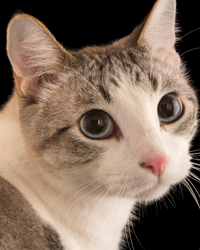

In [ ]:
# Show the iamge
display(Image.open('test.jpg').resize((200, 250)))

In the prompt, you can refer to images using the special `<image>` token. To indicate which text comes from a human vs. the model, one uses `USER` and `ASSISTANT` respectively. The format looks as follows:

```bash
USER: <image>\n<prompt>\nASSISTANT:
```

In [ ]:
# Load image from filesystem
image = Image.open("test.jpg").resize((200, 250))
prompt = "USER: <image>\nPlease describe this image?\nASSISTANT:"

# Preprocess the image and prompt into a format for LlaVa
inputs = processor(
    [prompt],
    images=[image],
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")
for k,v in inputs.items():
  print(k,v.shape)

In [ ]:
# Now we can pass the inputs to the model and generate
output = model.generate(**inputs, max_new_tokens=20)
generated_text = processor.batch_decode(output, skip_special_tokens=True)
for text in generated_text:
  print(text.split("ASSISTANT:")[-1])

Ok! We can see the model is able to correctly describe what is in the image.

Now, onto your task...

You are given a dataset of images of cars (label 0) and horses (label 1), but do not have annotations for which is which.

Like before, we will load the dataset from HuggingFace and hide the labels. You will be writing a zero shot image annotator below using LlaVa. At the end we will compare the quality of the automated annotations against the original.

In [ ]:
# DO NOT CHANGE CODE IN THIS CELL
from datasets import load_dataset

ds = load_dataset("uoft-cs/cifar10")
images = ds['train']['img']
hidden_labels = ds['train']['label']

# keep only labels for 1 (car) and 7 (horse)
images = [image for image, label in zip(images, hidden_labels) if label in [1, 7]]
hidden_labels = [label for label in hidden_labels if label in [1, 7]]
hidden_labels = [0 if label == 1 else 1 for label in hidden_labels]

# keep only 250
images = images[:250]
hidden_labels = hidden_labels[:250]

Let's take a look at a few of these images.

In [ ]:
images[0]

In [ ]:
images[1]

In [ ]:
images[2]

In the cell below, find areas with `# FILL ME OUT` to complete. You will write a prompt to do zero shot annotation on a dataset of images.

In [ ]:
class ZeroShotImageAnnotator:

  def create_prompt(self) -> str:
    r"""Create a prompt around the image to provide instructions for
    the LLM to annotate the image. Please craft your prompt such that
    the LLM returns a single integer label (0 for car, 1 for horse).

    For different LLMs, the format of the prompt may be different. For
    the LLM we are using, the format is:

    USER: <image>
    ...
    ASSISTANT:

    A bit of background:
    - The <image> is a placeholder for the image data
    - The `USER:` represents you - this is where you put your instruction.
    - The `ASSISTANT:` represents the LLM. It will populate its response here.

    Please follow this format for your prompt or you may find unexpected
    results. See https://huggingface.co/TheBloke/llava-v1.5-13B-GPTQ
    for examples. Please read that link carefully.

    :param text: The text to be annotated.
    :return: A prompt for the LLM.
    """
    prompt = ""
    # ====================
    # FILL ME OUT
    # ====================
    return prompt

  def parse_output(self, output: str) -> Optional[int]:
    label = None
    # ====================
    # FILL ME OUT
    # HINT: remove any whitespaces
    # ====================
    return label

  @torch.no_grad()
  def annotate(self, model, images) -> List[Optional[int]]:
    r"""Loops through image dataset and returns parsed labels.
    @note Returns `None` for generations that failed to parse.

    :param images: List of PIL images.
    :return: The parsed labels. May be none.
    """
    outputs = []
    for image in tqdm(images):
      prompt = self.create_prompt()
      # Preprocess the image and prompt into a format for LlaVa
      inputs = processor(
          [prompt],
          images=[image],
          padding=True,
          return_tensors="pt",
      )
      inputs = inputs.to("cuda")
      output = model.generate(**inputs, max_new_tokens=10)
      generated_text = processor.batch_decode(output, skip_special_tokens=True)
      output = generated_text[0].split("ASSISTANT:")[-1]
      output = self.parse_output(output)
      outputs.append(output)

    return outputs

In [ ]:
# Use this to test with the first 10 training examples
annotator = ZeroShotImageAnnotator()
sample = annotator.annotate(model, images[:10])  # first 10

# Sanity check: if you find `None`s in your labels, try finetuning you prompt.
# For example, add a guardrail that the LLM should only return 0 or 1.
assert None not in sample, "Looks like something is not right."

In [ ]:
# When you are ready, use the cell below to annotate all labels
# ~this roughly takes ~3-4min
annotator_zeroshot = ZeroShotImageAnnotator()
labels_zeroshot = annotator.annotate(model, images)

In [ ]:
is_match = np.array(hidden_labels) == np.array(labels_zeroshot)
accuracy_zeroshot = np.mean(is_match)
percent_zeroshot = round(accuracy_zeroshot * 100 * 10) / 10
print(f'LLM annotations are {percent_zeroshot}% accurate')

You should get an accuracy around ~80-90%. Try finetuning your prompt if you get below that.

# Done!

That's the last step for this part of the project. We hope you had fun playing with LLMs - both `vllm` and `huggingface` are popular libraries that you will likely see many times.